# Goals

 1) Construct a web scraper capable of gathering data from github repositories. Data collected should include the main programing language used in that repository, and the contents of that repository’s readme file.

 2) Use natural language processing to develop a model to predict each repositories programming language based on the contents of that repository’s readme file.

# Imports

In [1]:
import re
import unicodedata
import pandas as pd
import nltk

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#import acquire as a # produces output sometimes
import prepare as p
import explore as e

# Acqusition

In [2]:
# Calles functions in acquire.py to scrape git hub repositories and create a dictionary containing the repo url,
# language, and readme contents of each folder.

# Preperation

In [3]:
# Calls functions in prepare.py. Functions convert the dictionaries in the json file into a data frame. 
# Then add two columns to the data frame, applying basic cleaning algorithms to the readme contents. 
# Stemming is then applied to one of those columns. Lemmatize is applied to the other.
# Functions also drop rows that did not produce usable data
df = p.prep_readme()

# Exploration

In [4]:
# First peek at prepared data.
df.head()

,language,readme_contents,repo,readme_contents_stemmed,readme_contents_lemmatized
0,CSS,# Welcome\n\n> **Warning**: this book is **not...,/nakov/Practical-Cryptography-for-Developers-Book,welcom warn book finish still work chapter com...,welcome warning book finished still working ch...
1,Java,# Monorepo of Deeplearning4j\n\nWelcome to the...,/eclipse/deeplearning4j,monorepo deeplearn j welcom new monorepo deepl...,monorepo deeplearning j welcome new monorepo d...
2,Java,# H2O\n\n[![Join the chat at https://gitter.im...,/h2oai/h2o-3,h join chat http gitter im h oai h http badg g...,h join chat http gitter im h oai h http badge ...
3,C++,"<div align=""center"">\n <img src=""https://www....",/tensorflow/tensorflow,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...
4,C++,gRPC - An RPC library and framework\n=========...,/grpc/grpc,grpc rpc librari framework grpc modern open so...,grpc rpc library framework grpc modern open so...


In [5]:
# dropping repo column. The goal is to predict language using readme contents so repo it is not useful
df.drop(columns='repo',inplace=True)

In [6]:
# dropping readme_contents. The column was there for comparison to insure prepre functions worked as expected.
# It is no longer needed.
df.drop(columns='readme_contents',inplace=True)

In [7]:
df.head()

,language,readme_contents_stemmed,readme_contents_lemmatized
0,CSS,welcom warn book finish still work chapter com...,welcome warning book finished still working ch...
1,Java,monorepo deeplearn j welcom new monorepo deepl...,monorepo deeplearning j welcome new monorepo d...
2,Java,h join chat http gitter im h oai h http badg g...,h join chat http gitter im h oai h http badge ...
3,C++,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...
4,C++,grpc rpc librari framework grpc modern open so...,grpc rpc library framework grpc modern open so...


### Data Dictionary

1) language - main programing language used by the repository

2) readme_contents_stemmed - contents of readme file cleaned and stemed

3) readme_contents_lemmatized - contents of readme file cleaned and lemmatized

#### looking at initial data statistics

In [8]:
df.shape

(311, 3)

In [9]:
# shows the number and percent of repositories that represent each language
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['number', 'percent']
labels

,number,percent
HTML,60,0.192926
C++,59,0.189711
C,44,0.141479
JavaScript,38,0.122186
Java,37,0.118971
Python,36,0.115756
CSS,21,0.067524
Shell,16,0.051447


In [10]:
# gets a list of words tied to each language
CPP_words = e.word_soup(' '.join(df[df.language == 'C++'].readme_contents_lemmatized))
HTML_words = e.word_soup(' '.join(df[df.language == 'HTML'].readme_contents_lemmatized))
Python_words = e.word_soup(' '.join(df[df.language == 'Python'].readme_contents_lemmatized))
CSS_words = e.word_soup(' '.join(df[df.language == 'CSS'].readme_contents_lemmatized))
C_words = e.word_soup(' '.join(df[df.language == 'C'].readme_contents_lemmatized))
Java_words = e.word_soup(' '.join(df[df.language == 'Java'].readme_contents_lemmatized))
JavaScript_words = e.word_soup(' '.join(df[df.language == 'JavaScript'].readme_contents_lemmatized))
Shell_words = e.word_soup(' '.join(df[df.language == 'Shell'].readme_contents_lemmatized))
all_words = e.word_soup(' '.join(df.readme_contents_lemmatized))

In [11]:
# gets frequency of each word tied to each language
CPP_freq = pd.Series(CPP_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
CSS_freq = pd.Series(CSS_words).value_counts()
C_freq = pd.Series(C_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
Shell_freq = pd.Series(Shell_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [52]:
top_20_words = (pd.Series(all_words)
                      .value_counts()
                      .head(20))

Text(0.5, 0, '# Occurances')

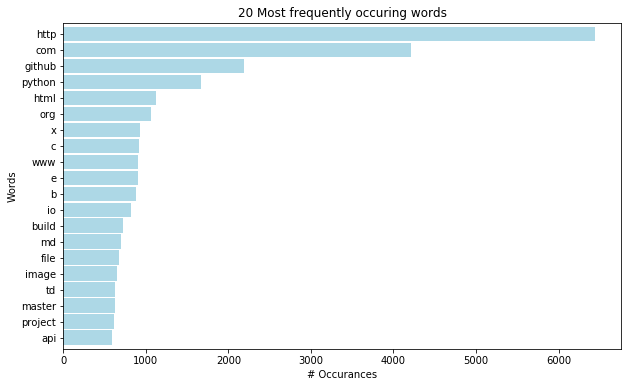

In [56]:
top_20_words.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring words')
plt.ylabel('Words')
plt.xlabel('# Occurances')

In [ ]:
top_20_words.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [12]:
# creates a data frame that shows the frequency of each word across each language
word_counts = (pd.concat([all_freq,CPP_freq,HTML_freq,Python_freq,CSS_freq,C_freq,Java_freq,JavaScript_freq,Shell_freq], axis=1, sort=True)
                .set_axis(['all', 'C++', 'HTML', 'Python', 'CSS', 'C', 'Java', 'JavaScript', 'Shell'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [13]:
word_counts.head()

,all,C++,HTML,Python,CSS,C,Java,JavaScript,Shell
aa,23,2,7,0,0,1,2,11,0
aaa,8,0,3,0,0,0,0,1,4
aaaa,5,0,0,1,0,0,4,0,0
aaaaaelftksuqmcc,1,1,0,0,0,0,0,0,0
aaaaaxrstlmaqobyzgaaaafis,1,1,0,0,0,0,0,0,0


In [14]:
# shows the 10 most frequently occuring words
word_counts.sort_values(by='all', ascending=False).head(10)

,all,C++,HTML,Python,CSS,C,Java,JavaScript,Shell
http,8000,1121,960,2455,338,465,718,1385,558
com,5160,652,534,1660,257,237,474,947,399
github,2791,359,275,924,183,164,331,303,252
python,2030,141,96,1271,53,99,51,43,276
html,1507,106,254,240,67,49,202,553,36
org,1405,321,147,415,30,127,194,104,67
x,1346,168,31,793,25,116,71,70,72
c,1289,213,96,317,17,266,96,188,96
b,1086,71,93,633,8,48,31,145,57
file,1080,160,255,151,22,164,89,89,150


In [15]:
# shows words that are unique to each language
Shell_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Shell', ascending=False)
CPP_unique = word_counts[(word_counts['Shell'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='C++', ascending=False)
HTML_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['Shell'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='HTML', ascending=False)
Python_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Shell'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Python', ascending=False)
CSS_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['Shell'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='CSS', ascending=False)
C_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['Shell'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='C', ascending=False)
Java_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Shell'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Java', ascending=False)
JavaScript_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['Shell'] == 0)].sort_values(by='JavaScript', ascending=False)

In [16]:
# idea create list of stop words that are all values except unique-to-language words from train group then
# try to predict test group

In [17]:
# looking at bigrams
# shows bigrams for data set
Shell_bigrams = pd.Series(nltk.ngrams(Shell_words, 2))
CPP_bigrams = pd.Series(nltk.ngrams(CPP_words, 2))
HTML_bigrams = pd.Series(nltk.ngrams(HTML_words, 2))
Python_bigrams = pd.Series(nltk.ngrams(Python_words, 2))
CSS_bigrams = pd.Series(nltk.ngrams(CSS_words, 2))
C_bigrams = pd.Series(nltk.ngrams(C_words, 2))
Java_bigrams = pd.Series(nltk.ngrams(Java_words, 2))
JavaScript_bigrams = pd.Series(nltk.ngrams(JavaScript_words, 2))
all_bigrams = pd.Series(nltk.ngrams(all_words, 2))

In [18]:
# Idea Vectorize using bigrams...ngrams

In [19]:
# Idea Could try looking at frequency of bigrams

In [20]:
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

Text(0.5, 0, '# Occurances')

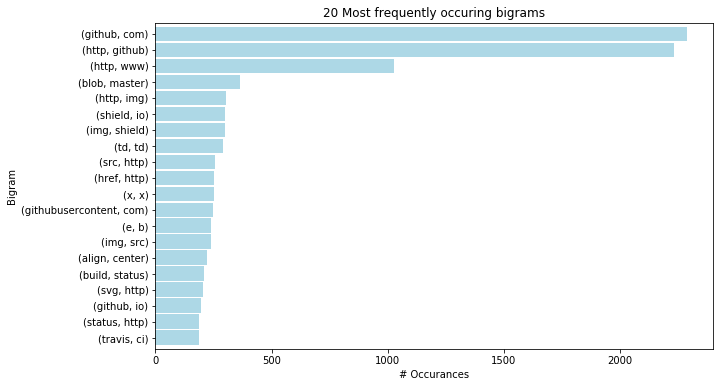

In [57]:
top_20_bigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

In [22]:
# Decided to drop readme_contents_stemmed. Limmitizing is reputed to the most accurate and because the data set is
# small the trade of in quicker computation time is negligable. There is also insufficient time to explore the 
# stem option any further.
df.drop(columns='readme_contents_stemmed',inplace=True)

In [23]:
df.head()

,language,readme_contents_lemmatized
0,CSS,welcome warning book finished still working ch...
1,Java,monorepo deeplearning j welcome new monorepo d...
2,Java,h join chat http gitter im h oai h http badge ...
3,C++,div align center img src http www tensorflow o...
4,C++,grpc rpc library framework grpc modern open so...


# Modeling

In [24]:
# Create baseline model

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents_lemmatized)
y = df.language

# Split Data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .2, random_state = 123)
    
# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.54
Accuracy of random forest classifier on training set: 0.27


Because there are 8 total languages we would expect an accuracy rating of .13 (rounded).

The Baseline model performed better than chance at .27 on test data

In [25]:
# Try baseline model using bigrams

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer(ngram_range=(2, 2))
X = tfidf.fit_transform(df.readme_contents_lemmatized)
y = df.language

# Split Data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .2, random_state = 123)
    
# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.37
Accuracy of random forest classifier on training set: 0.29


model Marginally improves using trigarms .29

In [26]:
# Try baseline model using trigrams

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer(ngram_range=(3, 3))
X = tfidf.fit_transform(df.readme_contents_lemmatized)
y = df.language

# Split Data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .2, random_state = 123)
    
# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.27
Accuracy of random forest classifier on training set: 0.27


In [27]:
# Try baseline model using Tetragrams

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer(ngram_range=(4, 4))
X = tfidf.fit_transform(df.readme_contents_lemmatized)
y = df.language

# Split Data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .2, random_state = 123)
    
# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.24
Accuracy of random forest classifier on training set: 0.24


In [28]:
# Try baseline model using bigrams and monograms

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(df.readme_contents_lemmatized)
y = df.language

# Split Data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .2, random_state = 123)
    
# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.44
Accuracy of random forest classifier on training set: 0.35


### Model using only bigrams has shown the best result .29

In [29]:
df.head()

,language,readme_contents_lemmatized
0,CSS,welcome warning book finished still working ch...
1,Java,monorepo deeplearning j welcome new monorepo d...
2,Java,h join chat http gitter im h oai h http badge ...
3,C++,div align center img src http www tensorflow o...
4,C++,grpc rpc library framework grpc modern open so...


In [30]:
# Create model using go-words

# Split Data into test and train with random state 999
train, test = train_test_split(df, stratify=df.language, train_size = .8, random_state = 999)

In [31]:
# get a list of words tied to each language in train
CPP_words = e.word_soup(' '.join(train[train.language == 'C++'].readme_contents_lemmatized))
HTML_words = e.word_soup(' '.join(train[train.language == 'HTML'].readme_contents_lemmatized))
Python_words = e.word_soup(' '.join(train[train.language == 'Python'].readme_contents_lemmatized))
CSS_words = e.word_soup(' '.join(train[train.language == 'CSS'].readme_contents_lemmatized))
C_words = e.word_soup(' '.join(train[train.language == 'C'].readme_contents_lemmatized))
Java_words = e.word_soup(' '.join(train[train.language == 'Java'].readme_contents_lemmatized))
JavaScript_words = e.word_soup(' '.join(train[train.language == 'JavaScript'].readme_contents_lemmatized))
Shell_words = e.word_soup(' '.join(train[train.language == 'Shell'].readme_contents_lemmatized))
all_words = e.word_soup(' '.join(train.readme_contents_lemmatized))

In [32]:
# gets frequency of each word tied to each language in train
CPP_freq = pd.Series(CPP_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
CSS_freq = pd.Series(CSS_words).value_counts()
C_freq = pd.Series(C_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
Shell_freq = pd.Series(Shell_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [33]:
# creates a data frame that shows the frequency of each word across each language in train
word_counts = (pd.concat([all_freq,CPP_freq,HTML_freq,Python_freq,CSS_freq,C_freq,Java_freq,JavaScript_freq,Shell_freq], axis=1, sort=True)
                .set_axis(['all', 'C++', 'HTML', 'Python', 'CSS', 'C', 'Java', 'JavaScript', 'Shell'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [34]:
word_counts.head()

,all,C++,HTML,Python,CSS,C,Java,JavaScript,Shell
aa,20,1,6,0,0,0,2,11,0
aaa,8,0,3,0,0,0,0,1,4
aaaa,5,0,0,1,0,0,4,0,0
aaaaaelftksuqmcc,1,1,0,0,0,0,0,0,0
aaaaaxrstlmaqobyzgaaaafis,1,1,0,0,0,0,0,0,0


In [35]:
# shows words that are unique to each language in train
Shell_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Shell', ascending=False)
CPP_unique = word_counts[(word_counts['Shell'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='C++', ascending=False)
HTML_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['Shell'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='HTML', ascending=False)
Python_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Shell'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Python', ascending=False)
CSS_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['Shell'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='CSS', ascending=False)
C_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['Shell'] == 0) & (word_counts['Java'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='C', ascending=False)
Java_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Shell'] == 0) & (word_counts['JavaScript'] == 0)].sort_values(by='Java', ascending=False)
JavaScript_unique = word_counts[(word_counts['C++'] == 0) & (word_counts['HTML'] == 0) &(word_counts['Python'] == 0) & (word_counts['CSS'] == 0) & (word_counts['C'] == 0) & (word_counts['Java'] == 0) & (word_counts['Shell'] == 0)].sort_values(by='JavaScript', ascending=False)

In [36]:
Shell_unique.head()

,all,C++,HTML,Python,CSS,C,Java,JavaScript,Shell
zsh,166,0,0,0,0,0,0,0,166
babun,161,0,0,0,0,0,0,0,161
passenger,141,0,0,0,0,0,0,0,141
ohmyzsh,78,0,0,0,0,0,0,0,78
oh,75,0,0,0,0,0,0,0,75


In [37]:
# join all words that are unique to one language together in one list
go_words = set(Shell_unique.index).union(set(CPP_unique.index)).union(set(HTML_unique.index)).union(set(Python_unique.index)).union(set(CSS_unique.index)).union(set(C_unique.index)).union(set(Java_unique.index)).union(set(JavaScript_unique.index))

In [38]:
# function removes words that are not in go_words from an string
def one_language_words(text):
    
    wnl = nltk.stem.WordNetLemmatizer()
 
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return ' '.join([word for word in words if word in go_words])

In [39]:
df['readme_contents_lemmatized'] = df['readme_contents_lemmatized'].apply(one_language_words)

In [40]:
df.head()

,language,readme_contents_lemmatized
0,CSS,epub patient svetlin nakov gitbook nakov crypt...
1,Java,monorepo deeplearning monorepo deeplearning de...
2,Java,oai oai seamlessly boosting forest forest stac...
3,C++,tf guaranteed subscribing announce announce ni...
4,C++,transparently simplifies googlegroups maven ex...


In [41]:
# Try decision tree using unique to language words

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df.readme_contents_lemmatized)

X = tfidfs
y = df.language

# split test and train into x and y test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df.language, train_size = .8, random_state = 999)

# create clasifier object and fit to data
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.26
Accuracy of Decision Tree classifier on test set: 0.24


In [42]:
# Try model using unique to language words

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df.readme_contents_lemmatized)

X = tfidfs
y = df.language

# split test and train into x and y test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df.language, train_size = .8, random_state = 999)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
rfc = RandomForestClassifier(random_state=123, min_samples_split=10,\
     n_estimators=100,n_jobs=-1, max_features="auto")
clf = AdaBoostClassifier(n_estimators=1,learning_rate=1,algorithm='SAMME',\
     random_state=123, base_estimator=rfc)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.19047619047619047

In [43]:
# Try model using unique to language words

# vectorize stemmed readme contents and assign X any y veriables
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df.readme_contents_lemmatized)

X = tfidfs
y = df.language

# split test and train into x and y test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df.language, train_size = .8, random_state = 999)

# Create Random Forest object and fit it to the data
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
        
rf.fit(X_train, y_train)

# print accuracy for train and test data sets
print('Accuracy of random forest classifier on training set: {:.2f}'
      .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on test set: {:.2f}'
      .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.23
Accuracy of random forest classifier on test set: 0.17


# Take Aways

To develop a more accurate model we would need to develop a much deeper understanding of how the vectorized data is processed. The result the go-words test went against our intuition. We believed that removing all of the words that were associated with more than one language would leave each of the readme contents with only words that were unique to the programming language of the readme, and that this would mean be an easy sort for the model. In reality the use of go-words seems to negatively affect the accuracy of the model.  This may be caused by go-words not increasing the predictive ability of the model and having the side effect of sometimes blanking entire readmes, if no matching words were found. It was thought that the upside of focusing the model on words unique to one language would net a better result. It does not. 